In [1]:
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
import pandas as pd

In [5]:
X = pd.read_csv("train.csv")
y = X.pop("Survived")

In [6]:
X["Age"].fillna(X.Age.mean(), inplace=True)

In [7]:
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)

In [8]:
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22,1,0,7.2500
1,2,1,38,1,0,71.2833
2,3,3,26,0,0,7.9250
3,4,1,35,1,0,53.1000
4,5,3,35,0,0,8.0500


In [9]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

In [10]:
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [11]:
model.oob_score_

0.1361695005913669

In [12]:
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [13]:
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [14]:
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"
X["Cabin"] = X.Cabin.apply(clean_cabin)

In [15]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    # Filling missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Creating an array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Updating X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [16]:
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [17]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print "C-stat: ", roc_auc_score(y, model.oob_prediction_)

C-stat:  0.863521128261


In [18]:
model.feature_importances_

array([  9.11384671e-02,   2.38891052e-01,   4.43567267e-02,
         2.15831071e-02,   2.15047796e-01,   1.43423437e-01,
         1.58822440e-01,   2.95342368e-03,   3.79055011e-03,
         6.47116172e-03,   4.30998991e-03,   8.59480266e-03,
         1.02403226e-03,   8.12054428e-04,   2.67741854e-02,
         6.64265010e-05,   1.06189189e-02,   0.00000000e+00,
         6.00379221e-03,   1.53176370e-02])

C:\Users\shru.shru-PC\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


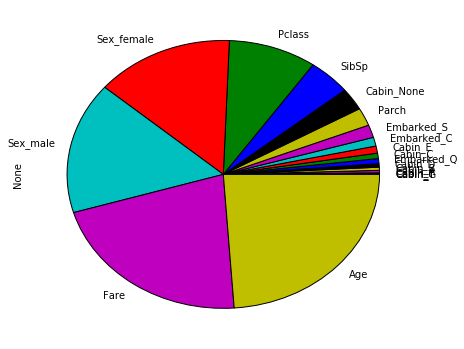

In [19]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="pie", figsize=(7,6));

C:\Users\shru.shru-PC\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


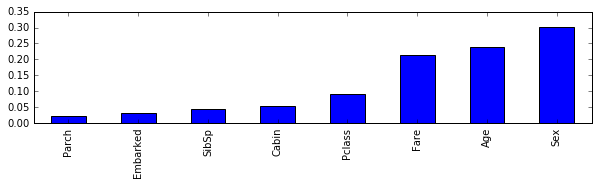

In [21]:
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #Few dummy columns need to be summarized
        for col_name in summarized_columns: 
            
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #Removing all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
                
            #Read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="bar", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

In [22]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=94)
model.fit(X, y)

1 loops, best of 3: 6.85 s per loop


30 trees
C-stat:  0.853875733657

50 trees
C-stat:  0.860698345743

100 trees
C-stat:  0.863521128261

200 trees
C-stat:  0.862192290076

500 trees
C-stat:  0.863739494456

1000 trees
C-stat:  0.864043076726

2000 trees
C-stat:  0.863449227197



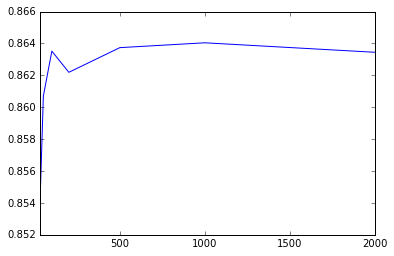

In [23]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print trees, "trees"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, n_estimator_options).plot();

auto option
C-stat:  0.861265565249

None option
C-stat:  0.861265565249

sqrt option
C-stat:  0.862551795396

log2 option
C-stat:  0.862551795396

0.9 option
C-stat:  0.863063091852

0.2 option
C-stat:  0.862551795396



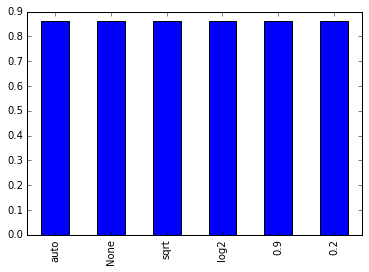

In [26]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=94, max_features=max_features)
    model.fit(X, y)
    print max_features, "option"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="bar", xlim=(.85,.88));

1 min samples
C-stat:  0.861265565249

2 min samples
C-stat:  0.868394422608

3 min samples
C-stat:  0.871302421202

4 min samples
C-stat:  0.873454127121

5 min samples
C-stat:  0.874103899701

6 min samples
C-stat:  0.874295635872

7 min samples
C-stat:  0.873235760926

8 min samples
C-stat:  0.871376985268

9 min samples
C-stat:  0.868943001097

10 min samples
C-stat:  0.866706079102



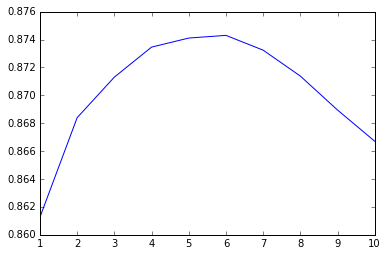

In [27]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=94, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print min_samples, "min samples"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

In [28]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=94, 
                              max_features="auto", 
                              min_samples_leaf=5)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print "C-stat: ", roc

C-stat:  0.874103899701
